# Introduction

## Project Overview

In this project, we aim to explore the correlation between student interactions with ChatGPT and their academic performance, specifically predicting homework scores. The dataset comprises html files of ChatGPT interactions, each uniquely identified and paired with the corresponding homework score.

## Project Objective

The primary objective is to develop a predictive model that accurately estimates homework scores based on the content and nature of ChatGPT interactions. This involves delving into the nuances of natural language processing, text analysis, and machine learning to decode the underlying patterns that may associate the depth, complexity, and context of the interactions with the eventual scores.

## Project Dataset

The dataset includes:

- A series of HTML files, each representing a ChatGPT session. These files are named with unique codes to maintain anonymity and order.
- A CSV file (scores.csv) containing the mapping of each unique session code to the actual homework score.

## Project Team Members
- Mustafa Harun Şendur
- İsmail Çakmak
- Pınar Şen
- Göktuğ Gökyılmaz


# Importing Necessary Libraries

In [1]:
import os
import re
import os
import tqdm
from glob import glob
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from pprint import pprint
import graphviz

from collections import defaultdict
from bs4 import BeautifulSoup

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

from sklearn import tree
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score


# Preprocessing

In [2]:
# Preprocessing and Drop Selections

do_preprocessing = True
drop_scores_lessthan_80 = True
drop_promptnum_lessthan_5 = True

In [3]:
# Transforming HTML files to dictionary format

data_path = "project-material/dataset/*.html"

code2convos = dict()

pbar = tqdm.tqdm(sorted(list(glob(data_path))))
for path in pbar:
    
    # print(Path.cwd() / path)
    file_code = os.path.basename(path).split(".")[0]
    with open(path, "r", encoding="latin1") as fh:

        # get the file id to use it as key later on
        fid = os.path.basename(path).split(".")[0]

        # read the html file
        html_page = fh.read()

        # parse the html file with bs4 so we can extract needed stuff
        soup = BeautifulSoup(html_page, "html.parser")

        # grab the conversations with the data-testid pattern
        data_test_id_pattern = re.compile(r"conversation-turn-[0-9]+")
        conversations = soup.find_all("div", attrs={"data-testid": data_test_id_pattern})

        convo_texts = []

        for i, convo in enumerate(conversations):
            convo = convo.find_all("div", attrs={"data-message-author-role":re.compile( r"[user|assistant]") })
            if len(convo) > 0:
                role = convo[0].get("data-message-author-role")
                convo_texts.append({
                        "role" : role,
                        "text" : convo[0].text
                    }
                )

        code2convos[file_code] = convo_texts

100%|██████████| 127/127 [00:06<00:00, 18.20it/s]


#### Things to do:
- Prompt matching with questions
- Feature Engineering
- Question Grades preparation
- Train/Test split
- Fitting a model for predicting the scores

# Working on Dataset and Analysing

In [4]:
prompts = []
code2prompts = defaultdict(list)
for code , convos in code2convos.items():
    user_prompts = []
    for conv in convos:
        if conv["role"] == "user":
            prompts.append(conv["text"])
            user_prompts.append(conv["text"])
    code2prompts[code] = user_prompts

In [5]:
questions = [
    """Initialize
*   First make a copy of the notebook given to you as a starter.
*   Make sure you choose Connect form upper right.
*   You may upload the data to the section on your left on Colab, than right click on the .csv file and get the path of the file by clicking on "Copy Path". You will be using it when loading the data.

""",
#####################
    """Load training dataset (5 pts)
    *  Read the .csv file with the pandas library
""",
#####################
"""Understanding the dataset & Preprocessing (15 pts)
Understanding the Dataset: (5 pts)
> - Find the shape of the dataset (number of samples & number of attributes). (Hint: You can use the **shape** function)
> - Display variable names (both dependent and independent).
> - Display the summary of the dataset. (Hint: You can use the **info** function)
> - Display the first 5 rows from training dataset. (Hint: You can use the **head** function)
Preprocessing: (10 pts)

> - Check if there are any missing values in the dataset. If there are, you can either drop these values or fill it with most common values in corresponding rows. **Be careful that you have enough data for training the  model.**

> - Encode categorical labels with the mappings given in the cell below. (Hint: You can use **map** function)
""",
"""Set X & y, split data (5 pts)

*   Shuffle the dataset.
*   Seperate your dependent variable X, and your independent variable y. The column health_metrics is y, the rest is X.
*   Split training and test sets as 80% and 20%, respectively.
""",
#####################
"""Features and Correlations (10 pts)

* Correlations of features with health (4 points)
Calculate the correlations for all features in dataset. Highlight any strong correlations with the target variable. Plot your results in a heatmap.

* Feature Selection (3 points)
Select a subset of features that are likely strong predictors, justifying your choices based on the computed correlations.

* Hypothetical Driver Features (3 points)
Propose two hypothetical features that could enhance the model's predictive accuracy for Y, explaining how they might be derived and their expected impact. Show the resulting correlations with target variable.

* __Note:__ You get can get help from GPT.
""",
#####################
"""Tune Hyperparameters (20 pts)
* Choose 2 hyperparameters to tune. You can use the Scikit learn decision tree documentation for the available hyperparameters *(Hyperparameters are listed under "Parameters" in the documentation)*. Use GridSearchCV for hyperparameter tuning, with a cross-validation value of 5. Use validation accuracy to pick the best hyper-parameter values. (15 pts)
-Explain the hyperparameters you chose to tune. *(What are the hyperparameters you chose? Why did you choose them?)* (5 pts)
""",
#####################
"""Re-train and plot the decision tree with the hyperparameters you have chosen (15 pts)
- Re-train model with the hyperparameters you have chosen in part 5). (10 pts)
- Plot the tree you have trained. (5 pts)
Hint: You can import the **plot_tree** function from the sklearn library.
""",
#####################
"""Test your classifier on the test set (20 pts)
- Predict the labels of testing data using the tree you have trained in step 6. (10 pts)
- Report the classification accuracy. (2 pts)
- Plot & investigate the confusion matrix. Fill the following blanks. (8 pts)
> The model most frequently mistakes class(es) _________ for class(es) _________.
Hint: You can use the confusion_matrix function from sklearn.metrics
""",
#####################
"""Find the information gain on the first split (10 pts)""",
#####################
]

In [6]:
# Preprocessing Continued

import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
import string

nltk.download('stopwords')
nltk.download('wordnet')

def has_number(word):
    # Define a regular expression pattern to match any digit (0-9)
    pattern = r'\d'

    # Use the pattern to search for a digit in the word
    if re.search(pattern, word):
        return True
    else:
        return False

def is_ascii(word):
    ascii_characters = [
    '\x00', '\x01', '\x02', '\x03', '\x04', '\x05', '\x06', '\x07', '\x08', '\x09', '\x0a', '\x0b', '\x0c', '\x0d', '\x0e', '\x0f',
    '\x10', '\x11', '\x12', '\x13', '\x14', '\x15', '\x16', '\x17', '\x18', '\x19', '\x1a', '\x1b', '\x1c', '\x1d', '\x1e', '\x1f',
    ' ', '!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9',
    ':', ';', '<', '=', '>', '?', '@', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T',
    'U', 'V', 'W', 'X', 'Y', 'Z', '[', '\\', ']', '^', '_', '`', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n',
    'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '{', '|', '}', '~', '\x7f']

    for char in word:
        if char not in ascii_characters:
            return False

    return True


def preprocess_text(input_text):

    # remove words that include non-ascii characters
    words = input_text.split(" ")
    filtered_words = [word for word in words if is_ascii(word)]
    input_text = ' '.join(filtered_words)

    # remove words that include numbers
    words = input_text.split(" ")
    filtered_words = [word for word in words if not has_number(word)]
    input_text = ' '.join(filtered_words)

    # remove words that include less than 3 characters or more than 25 characters
    words = input_text.split(" ")
    filtered_words = [word for word in words if ((len(word)>2)and(len(word)<25))]
    input_text = ' '.join(filtered_words)

    # Step 1: Convert text to lowercase
    input_text = input_text.lower()

    # Step 2: Remove punctuation and special characters
    translator = str.maketrans('', '', string.punctuation)
    input_text = input_text.translate(translator)

    # Step 3: Tokenize the text (split it into words)
    words = input_text.split()

    # Step 6: Perform lemmatization
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word) for word in words]

    # Step 7: Join the preprocessed words back into a string
    preprocessed_text = ' '.join(words)

    return preprocessed_text


if do_preprocessing:
  #Proproces all text in code2convos
  for code, convos in code2convos.items():
      for convo in convos:
          convo["text"] = preprocess_text(convo["text"])

  #do preprocessing to questions
  preprocessed_questions = []
  for x in questions:
      x = preprocess_text(x)
      preprocessed_questions.append(x)
  questions = preprocessed_questions

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/mhsendur/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/mhsendur/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [7]:
vectorizer = TfidfVectorizer()
vectorizer = vectorizer.fit(prompts + questions)

questions_TF_IDF = pd.DataFrame(vectorizer.transform(questions).toarray(), columns=vectorizer.get_feature_names_out())
questions_TF_IDF.head()

,00000,000000,000196,000282,000284,000360,000469,000750,000886,000991,...,yticks,yã,yä,zaman,zdã¼m,zero,zerodivisionerror,zeroth,zip,ã¼nã¼yorum
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
code2prompts_tf_idf = dict()
for code, user_prompts in code2prompts.items():
    if len(user_prompts) == 0:
        # some files have issues
        print(code+".html")
        continue
    prompts_TF_IDF = pd.DataFrame(vectorizer.transform(user_prompts).toarray(), columns=vectorizer.get_feature_names_out())
    code2prompts_tf_idf[code] = prompts_TF_IDF

code2prompts_tf_idf["089eb66d-4c3a-4f58-b98f-a3774a2efb34"].shape

139235c7-736c-4237-92f0-92e8c116832c.html
668ad17e-0240-49f7-b5a7-d22e502554c6.html
b0640e51-6879-40cb-a4f5-329f952ef99d.html
da6b70d5-29f6-491a-ad46-037c77067128.html


(86, 5405)

In [9]:
code2cosine = dict()
for code, user_prompts_tf_idf in code2prompts_tf_idf.items():
    code2cosine[code] = pd.DataFrame(cosine_similarity(questions_TF_IDF,user_prompts_tf_idf))

In [10]:
code2questionmapping = dict()
for code, cosine_scores in code2cosine.items():
    code2questionmapping[code] = code2cosine[code].max(axis=1).tolist()


question_mapping_scores = pd.DataFrame(code2questionmapping).T
question_mapping_scores.reset_index(inplace=True)
question_mapping_scores.rename(columns={i: f"Q_{i}" for i in range(len(questions))}, inplace=True)
question_mapping_scores.rename(columns={"index" : "code"}, inplace=True)


# Feature Engineering
- Number of prompts that a users asked
- Number of complaints that a user makes e.g "the code gives this error!"
- User prompts average number of characters

In [11]:
!pip install textstat

In [12]:
#HARUN 
'''
- question_marks 
- exclamation_marks 
- code_patterns 
- math_expressions 
- code_patterns_gpt
- math_expressions_gpt
- flesch_readability 
- smog_index
- hw_terms
'''

import textstat

code2features = defaultdict(lambda : defaultdict(int))

keywords2search = ["error", "no", "thanks","next", "Entropy"]
keywords2search = [k.lower() for k in keywords2search]

# HARUN - specific concepts from homework occuring in user prompts
hw_terms = ["hyperparameter", "split", "train", "test"]
hw_terms = [term.lower() for term in hw_terms]  # convert to lowercase for case-insensitive matching

# HARUN - regex patterns for code-like patterns and mathematical expressions
code_pattern = re.compile(r'(function\s+\w+\s*\(|\bfor\b|\bwhile\b|\bif\b|\belse\b|{|}|\;)')
math_pattern = re.compile(r'(\d+\s*[+\-*\/]\s*\d+|\=\s*\d+|\bpi\b|\bsqrt\b|\b\d+\^\d+\b)')  # simple pattern for basic math expressions

for code, convs in code2convos.items():

    if len(convs) == 0:
        print(code)
        continue

    # HARUN - Initialize variables for readability scores calculation
    total_text = ''

    for c in convs:
        text = c["text"].lower()
        if c["role"] == "user":
            # User Prompts

            # HARUN - count the question and exclamation marks
            code2features[code]["#question_marks"] += text.count('?')
            code2features[code]["#exclamation_marks"] += text.count('!')


            # count the user prompts
            code2features[code]["#user_prompts"] += 1

            # count the keywords and hw terms
            for kw in keywords2search + hw_terms:
                code2features[code][f"#{kw}"] +=  len(re.findall(rf"\b{kw}\b", text))

            # HARUN - count code patterns and math expressions
            code2features[code]["#code_patterns"] += len(code_pattern.findall(text))
            code2features[code]["#math_expressions"] += len(math_pattern.findall(text))

            code2features[code]["prompt_avg_chars"] += len(text)

            # HARUN - Accumulate text for readability score calculation
            total_text += text + ' '
        else:
            # ChatGPT Responses
            code2features[code]["response_avg_chars"] += len(text)

            code2features[code]["#code_patterns_gpt"] += len(code_pattern.findall(text))
            code2features[code]["#math_expressions_gpt"] += len(math_pattern.findall(text))

    # Averaging the character counts over the number of prompts
    if code2features[code]["#user_prompts"] > 0:

        code2features[code]["prompt_avg_chars"] /= code2features[code]["#user_prompts"]
        code2features[code]["response_avg_chars"] /= code2features[code]["#user_prompts"]

    # HARUN - Calculate readability scores for accumulated text
    if total_text.strip() != '':
        code2features[code]["flesch_readability"] = textstat.flesch_reading_ease(total_text)
        code2features[code]["smog_index"] = textstat.smog_index(total_text)



139235c7-736c-4237-92f0-92e8c116832c
668ad17e-0240-49f7-b5a7-d22e502554c6
b0640e51-6879-40cb-a4f5-329f952ef99d
da6b70d5-29f6-491a-ad46-037c77067128


In [13]:
#ISMAIL

#FEATURE : user_clarify_point -> User promptlarındaki hata kelimelerinin oranı
#FEATURE : gpt_clarify_point  -> GPT cevaplarındaki hata kelime oranı

misunderstanding_words = [
    "No", "meant","not", "asking","misunderstood", "confused", "off", "rephrase","not right", "incorrect", "Sorry", "maybe", "clear", "clarify"
]

misunderstanding_words = [k.lower() for k in misunderstanding_words]

for code, convs in code2convos.items():

  user_numberofmisunderstood_words = 0
  gpt_numberofmisunderstood_words = 0
  user_total_number_of_words = 0
  gpt_total_number_of_words = 0

  if len(convs) == 0:
      print(code)
      continue

  for c in convs:
      text = c["text"].lower()


      if c["role"] == "user":
          # User Prompts
          user_total_number_of_words += len(text.split(" "))

          # count the keywords
          for kw in misunderstanding_words:
              user_numberofmisunderstood_words += len(re.findall(rf"\b{kw}\b", text))

      else:
          # ChatGPT Responses

          gpt_total_number_of_words += len(text.split(" "))

          # count the keywords
          for kwG in misunderstanding_words:
              gpt_numberofmisunderstood_words +=  len(re.findall(rf"\b{kwG}\b", text))


  code2features[code]["user_clarify_point"] = (user_numberofmisunderstood_words/user_total_number_of_words)*100
  code2features[code]["gpt_clarify_point"] = (gpt_numberofmisunderstood_words /gpt_total_number_of_words)*100



139235c7-736c-4237-92f0-92e8c116832c
668ad17e-0240-49f7-b5a7-d22e502554c6
b0640e51-6879-40cb-a4f5-329f952ef99d
da6b70d5-29f6-491a-ad46-037c77067128


In [14]:
#ISMAIL
#FEATURE : user_caps_rate -> ratio of number of CAPS words to all words
#FEATURE : gpt_caps_rate -> ratio of number of CAPS words to all words


for code, convs in code2convos.items():

  user_caps_words = 0
  gpt_caps_words = 0
  user_total_number_of_words = 0
  gpt_total_number_of_words = 0

  if len(convs) == 0:
      print(code)
      continue

  for c in convs:

    #YUKARDAKİ CELLDE TEXT'i split ettiğimiz için burada etmemiz lazım


      if c["role"] == "user":
          # User Prompts
          user_total_number_of_words += len(text)

          # count CAPS words
          caps_words = [word for word in text if word.isupper()]
          user_caps_words = user_caps_words + len(caps_words)

      else:
          # ChatGPT Responses
          gpt_total_number_of_words += len(text)

          # count CAPS words
          caps_words = [word for word in text if word.isupper()]
          gpt_caps_words = gpt_caps_words + len(caps_words)


  code2features[code]["user_caps_rate"] = (user_numberofmisunderstood_words/user_total_number_of_words)*100
  code2features[code]["gpt_caps_rate"] = (gpt_numberofmisunderstood_words /gpt_total_number_of_words)*100


139235c7-736c-4237-92f0-92e8c116832c
668ad17e-0240-49f7-b5a7-d22e502554c6
b0640e51-6879-40cb-a4f5-329f952ef99d
da6b70d5-29f6-491a-ad46-037c77067128


In [15]:
! pip install gensim
! pip install textblob

In [16]:
#PINAR
from textblob import TextBlob
from collections import defaultdict

# Iterate over each conversation code and its corresponding user prompts
for code, user_prompts in code2prompts.items():
    # Calculate total polarity and subjectivity for each user prompt
    for prompt in user_prompts:
        blob = TextBlob(prompt.lower())
        sentiment = blob.sentiment
        code2features[code]["total_polarity"] += sentiment.polarity
        code2features[code]["total_subjectivity"] += sentiment.subjectivity

    # Calculate average sentiment values if there are user prompts
    num_user_prompts = len(user_prompts)
    if num_user_prompts > 0:
        code2features[code]["avg_polarity"] = code2features[code]["total_polarity"] / num_user_prompts
        code2features[code]["avg_subjectivity"] = code2features[code]["total_subjectivity"] / num_user_prompts

In [17]:
# PINAR
# preprocessing needed before EMOTION ANALYSIS USING THE LEXICON:
# remove html, lowercase, remove punctuation, tokenization, remove stop word, possibly stemming

# AFTER preprocessing

import csv

# Load the NRC Emotion Lexicon
emotion_lexicon = {}
with open('NRC-Emotion-Lexicon-Wordlevel-v0.92.txt', 'r') as file:
    reader = csv.reader(file, delimiter='\t')
    for word, emotion, association in reader:
        if word not in emotion_lexicon:
            emotion_lexicon[word] = {}
        emotion_lexicon[word][emotion] = int(association)

# Function to analyze emotions in a text
def analyze_emotions(text, lexicon):
    words = text.lower().split()
    emotion_counts = {emotion: 0 for emotion in lexicon[next(iter(lexicon))].keys()}
    for word in words:
        if word in lexicon:
            for emotion, associated in lexicon[word].items():
                if associated == 1:
                    emotion_counts[emotion] += 1
    return emotion_counts

# Applying the emotion analysis to each user prompt
for code, user_prompts in code2prompts.items():
    # Initialize a dictionary to store aggregated emotion counts for each code
    aggregated_emotion_counts = {emotion: 0 for emotion in next(iter(emotion_lexicon.values())).keys()}

    for prompt in user_prompts:
        emotion_counts = analyze_emotions(prompt, emotion_lexicon)
        # Aggregate the emotion counts
        for emotion, count in emotion_counts.items():
            aggregated_emotion_counts[emotion] += count

    # Store the aggregated emotion counts in code2features
    code2features[code].update(aggregated_emotion_counts)

# list of emotions NRC lexicon uses: Anger, Anticipation, Disgust, Fear, Joy, Sadness, Surprise, Trust, positive, negative
# ustte tum emotionlari aggregate ediyo alttaki gibi sadece top veya highest freq olanlari alabiliriz
# frequency and top emotions
def analyze_emotions(text, lexicon):
    words = text.lower().split()
    emotion_counts = {emotion: 0 for emotion in lexicon[next(iter(lexicon))].keys()}

    # Count emotions
    total_emotions_count = 0
    for word in words:
        if word in lexicon:
            for emotion, associated in lexicon[word].items():
                if associated == 1:
                    emotion_counts[emotion] += 1
                    total_emotions_count += 1

    # Calculate affect frequencies
    affect_frequencies = {emotion: count / total_emotions_count for emotion, count in emotion_counts.items() if total_emotions_count > 0}

    # Find the highest emotions
    highest_emotions = sorted(emotion_counts, key=emotion_counts.get, reverse=True)[:2]  # top 2 emotions

    return highest_emotions, affect_frequencies

In [18]:
#GOKTUG
# accuracy_score
code2prompt_mapping = dict()

threshold = 0.2

# Iterate over codes and cosine scores
for code, cosine_scores in code2cosine.items():
    # Find the index of the maximum cosine score for each code
    max_cosine_index = cosine_scores.idxmax(axis=0)

    # Create a mapping of prompts to question IDs based on the maximum cosine score
    prompt_mapping = {
        f"prompt {i + 1}": {
            "question_id": f"Q{max_cosine_index[i] + 1}",
            "accuracy_score": cosine_scores[i].max()
        } for i in range(len(max_cosine_index))
    }

    # Check if any prompt has an accuracy score below the threshold, and set the question ID to Q10
    for prompt, values in prompt_mapping.items():
        if (prompt != "prompt 1"):
          if values["accuracy_score"] < threshold:
            indx = int(prompt[6::])
            newpromtindx = "prompt " + str(indx-1)
            prompt_mapping[prompt]["question_id"] = prompt_mapping[newpromtindx]["question_id"]


    # Store the mapping in the dictionary
    code2prompt_mapping[code] = prompt_mapping

    """# Print the resulting mapping
    for code, prompt_mapping in code2prompt_mapping.items():
        print(f"Code: {code}, Prompt Mapping: {prompt_mapping}")"""


In [19]:
#Göktuğ
# solve_one_by_one
for code, cosine_scores in code2cosine.items():
  solve_by_one_by = 1
  for prompt, values in prompt_mapping.items():

    if (prompt != "prompt 1"):
      indx = int(prompt[6::])
      newpromtindx = "prompt " + str(indx-1)
      if (int(prompt_mapping[newpromtindx]["question_id"][1::]) < int(prompt_mapping[prompt]["question_id"][1::])):
        solve_by_one_by -= (1 / code2features[code]['#user_prompts'])
  #print(code, solve_by_one_by)
  code2features[code]["solve_one_by_one"] = round(solve_by_one_by, 5)


In [20]:
#Göktuğ
#Q4_count...


# Initialize a dictionary to store the counts for each question for each user
user_question_counts = {}

# Iterate over prompt mappings for each user
for code, prompt_mapping in code2prompt_mapping.items():
    # Initialize a dictionary to store the counts for each question for the current user
    user_counts = {}

    # Count the occurrences of each question ID in the prompt mapping for the current user
    for values_dict in prompt_mapping.values():
        # Access the 'question_id' from the dictionary
        question_id = values_dict.get("question_id", "unknown")

        # Count the occurrences
        user_counts[question_id] = user_counts.get(question_id, 0) + 1

    # Optionally, sort the user_counts dictionary based on keys
    user_counts_sorted = dict(sorted(user_counts.items(), key=lambda x: x[0]))

    # Store the sorted counts for the current user in the main dictionary
    user_question_counts[code] = user_counts_sorted

# Print the resulting sorted question counts for each user
for code, user_counts_sorted in user_question_counts.items():

  questions = ["Q1", "Q2", "Q3", "Q4", "Q5", "Q6", "Q7", "Q8", "Q9"]

  for question in questions:
      if user_counts_sorted.get(question) is None:
          code2features[code][f"{question}_count"] = 0
      else:
          code2features[code][f"{question}_count"] = user_counts_sorted[question]


  #print(f"User {code}: {user_counts_sorted}")

### Processing


In [21]:
df = pd.DataFrame(code2features).T
df.head(5)


# reading the scores
scores = pd.read_csv("project-material/scores.csv", sep=",")
scores["code"] = scores["code"].apply(lambda x: x.strip())

# selecting the columns we need and we care
scores = scores[["code", "grade"]]

# show some examples
scores.head()

,code,grade
0,6a2003ad-a05a-41c9-9d48-e98491a90499,90.0
1,04f91058-d0f8-4324-83b2-19c671f433dc,97.0
2,81fdeb2a-e7e5-4a05-8058-d31ea579b0d9,94.0
3,6a903495-c5be-4263-b4dd-75e2bbc30434,97.0
4,6d5742c1-77c4-429c-8f6e-ef1262ca5557,93.0


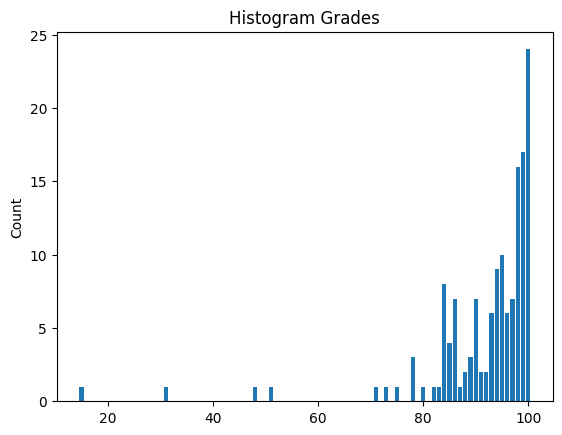

In [22]:
# Let's check grades distribution

plt.title('Histogram Grades')
plt.hist(scores["grade"], rwidth=.8, bins=np.arange(min(scores["grade"]), max(scores["grade"])+2) - 0.5)
plt.ylabel('Count')
plt.show()

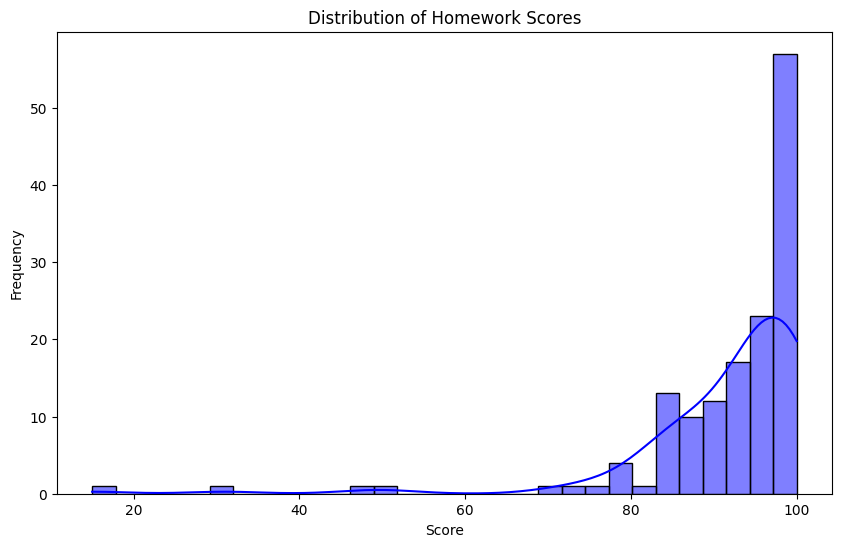

In [23]:
# HARUN - Better Visualization of Homework Scores Distribution
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.histplot(scores['grade'], kde=True, color='blue', bins=30)
plt.title('Distribution of Homework Scores')
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.show()


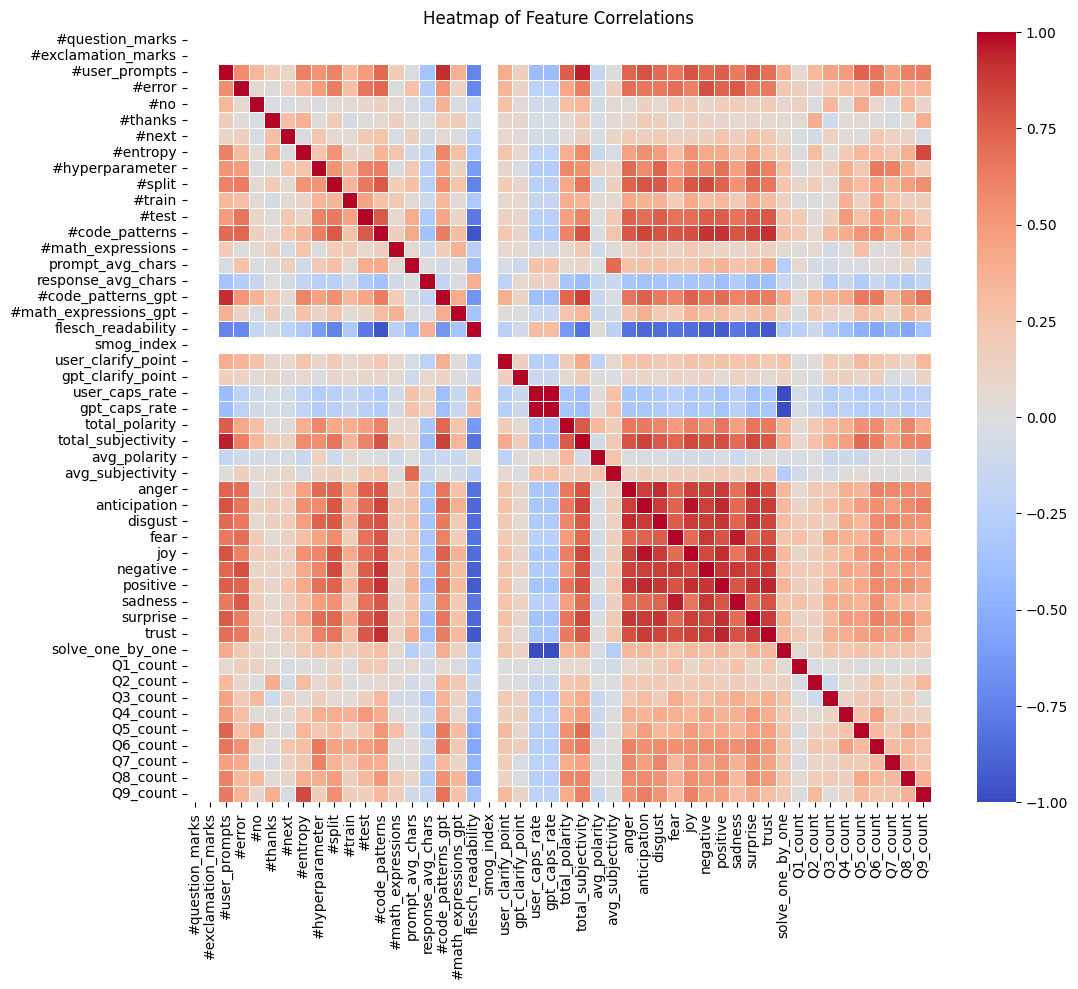

In [24]:
# HARUN - Heatmap of Feature Correlations
plt.figure(figsize=(12, 10))
sns.heatmap(df.corr(), annot=False, cmap='coolwarm', linewidths=.5)
plt.title('Heatmap of Feature Correlations')
plt.show()

#### Merging scores with features

In [25]:
# df and question mapping merged; then scores intergrated

df.reset_index(inplace=True, drop=False)
df.rename(columns={"index": "code"}, inplace=True)

df = pd.merge(df, question_mapping_scores, on="code", how="left")

temp_df = pd.merge(df, scores, on='code', how="left")
temp_df.dropna(inplace=True)
temp_df.drop_duplicates("code",inplace=True, keep="first")

In [26]:
# Dropping scores less than 80 and prompts less than five
grade_mean = (temp_df['grade'].mean())
grade_std = (temp_df['grade'].std())
print(grade_mean)
print(grade_std)
if drop_scores_lessthan_80:
  print(temp_df.shape)
  temp_df = temp_df[temp_df['grade'] >= grade_mean-2*grade_std]
  temp_df = temp_df[temp_df['grade'] <= grade_mean+2*grade_std]
  print(temp_df.shape)

if drop_promptnum_lessthan_5:
  temp_df = temp_df[temp_df['#user_prompts'] >= 5]

91.75409836065573
12.419200993323171
(122, 59)
(118, 59)


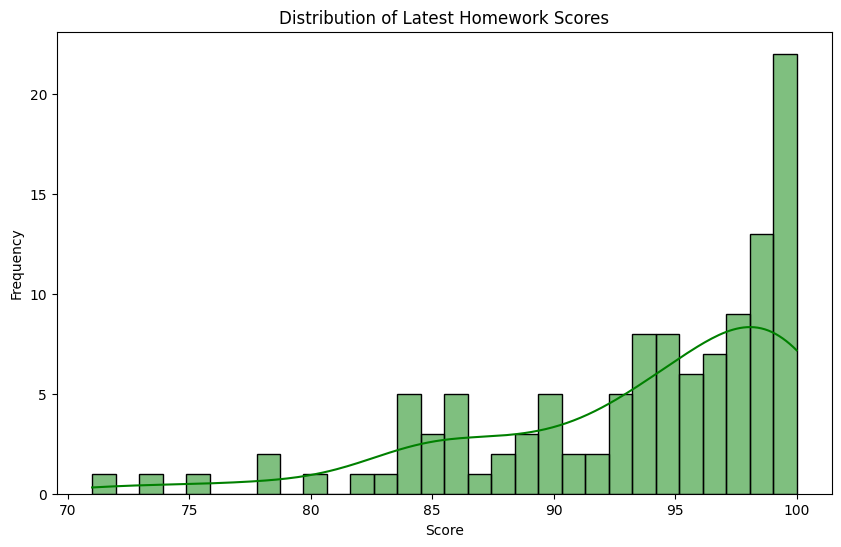

In [42]:
# HARUN - Homework Scores Distribution After Eliminating Some Scores
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.histplot(temp_df['grade'], kde=True, color='green', bins=30)
plt.title('Distribution of Latest Homework Scores')
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.show()


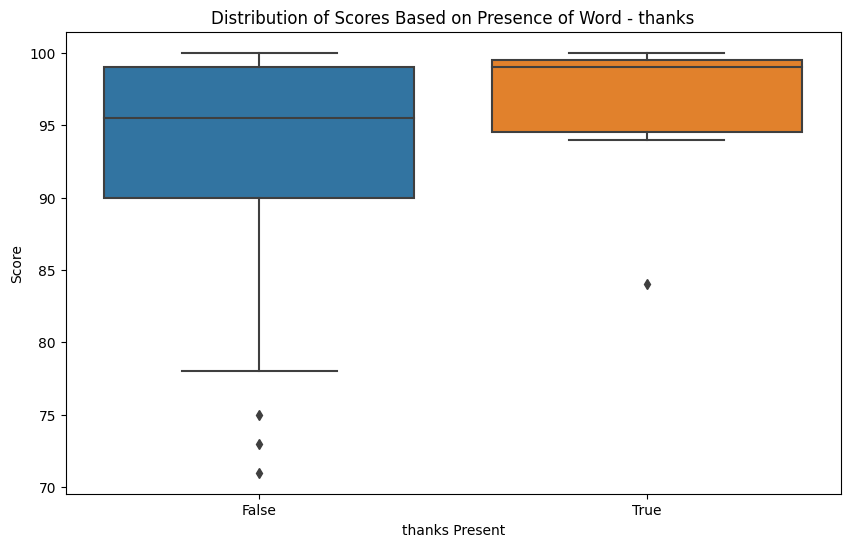

In [27]:
# HARUN -  Visualization: Boxplot of Scores by Presence of Thanks Keyword
specific_keyword = 'thanks'

plt.figure(figsize=(10, 6))
sns.boxplot(x=df[f'#{specific_keyword}'] > 0, y=temp_df['grade'])
plt.title(f'Distribution of Scores Based on Presence of Word - {specific_keyword}')
plt.xlabel(f'{specific_keyword} Present')
plt.ylabel('Score')
plt.show()


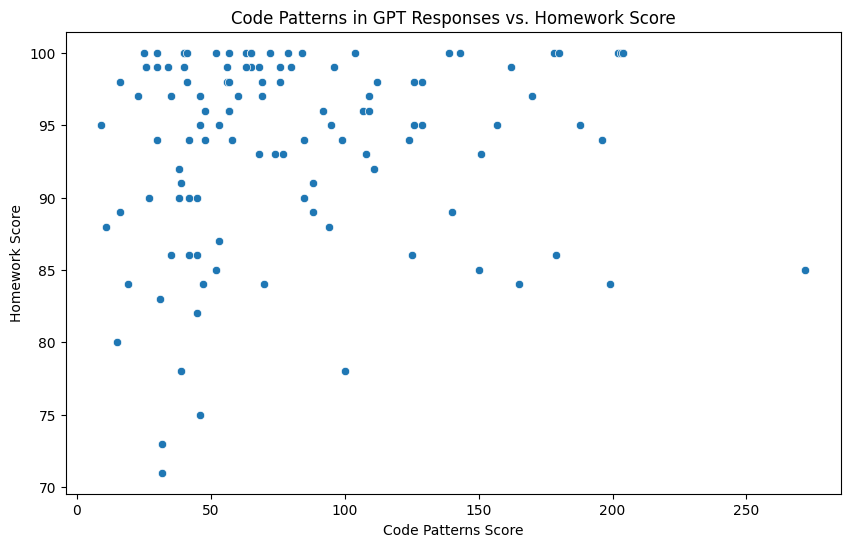

In [28]:
# HARUN - Visualization: Code Pattern Scores vs. Homework Scores
plt.figure(figsize=(10, 6))
sns.scatterplot(x=temp_df['#code_patterns_gpt'], y=temp_df['grade'])
plt.title('Code Patterns in GPT Responses vs. Homework Score')
plt.xlabel('Code Patterns Score')
plt.ylabel('Homework Score')
plt.show()


#### Predicting and Analyzing

In [29]:
# Selecting which features to use.

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Listed the features to be included

"""
All the features are below.

 '#user_prompts','#error', '#no', '#thanks', 'prompt_avg_chars',
       'response_avg_chars', 'Q_0', 'Q_1', 'Q_2', 'Q_3', 'Q_4', 'Q_5', 'Q_6',
       'Q_7', 'Q_8',

['code', '#question_marks', '#exclamation_marks', '#user_prompts',
       '#error', '#no', '#thanks', '#next', '#entropy', '#hyperparameter',
       '#split', '#train', '#test', '#code_patterns', '#math_expressions',
       'prompt_avg_chars', 'response_avg_chars', '#code_patterns_gpt',
       '#math_expressions_gpt', 'flesch_readability', 'smog_index',
       'user_clarify_point', 'gpt_clarify_point', 'user_caps_rate',
       'gpt_caps_rate', 'total_polarity', 'total_subjectivity', 'avg_polarity',
       'avg_subjectivity', 'anger', 'anticipation', 'disgust', 'fear', 'joy',
       'negative', 'positive', 'sadness', 'surprise', 'trust',
       'solve_one_by_one', 'Q1_count', 'Q2_count', 'Q3_count', 'Q4_count',
       'Q5_count', 'Q6_count', 'Q7_count', 'Q8_count', 'Q9_count', 'Q_0',
       'Q_1', 'Q_2', 'Q_3', 'Q_4', 'Q_5', 'Q_6', 'Q_7', 'Q_8', 'grade']

"""

# Features to be included to test

# Do not get rid of "code" and "grade" below.
features_to_include = ['code', '#no', 'Q1_count', 'Q2_count', 'anticipation', '#error', 'grade']



# Prepare the feature matrix X and the target vector y
simplified_df = temp_df[features_to_include]

print("After simplifaction : ", simplified_df.columns)

X = simplified_df[simplified_df.columns[1:-1]].to_numpy()
y = simplified_df["grade"].to_numpy()

After simplifaction :  Index(['code', '#no', 'Q1_count', 'Q2_count', 'anticipation', '#error',
       'grade'],
      dtype='object')


In [30]:
#Cross-Validation + Startification
from sklearn.ensemble import RandomForestRegressor

import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Assuming X, y, and a categorical feature 'strata' for stratification are defined

# Create StratifiedKFold object
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Lists to store metrics for each fold
mse_train_scores = []
mse_test_scores = []
r2_train_scores = []
r2_test_scores = []

for train_index, test_index in skf.split(X, y):
    # Splitting the data
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Training the model
    regressor = RandomForestRegressor(random_state=0, criterion='squared_error', max_depth=5)
    regressor.fit(X_train, y_train)

    # Predictions
    y_train_pred = regressor.predict(X_train)
    y_test_pred = regressor.predict(X_test)

    # Metrics
    mse_train = mean_squared_error(y_train, y_train_pred)
    mse_test = mean_squared_error(y_test, y_test_pred)
    r2_train = r2_score(y_train, y_train_pred)
    r2_test = r2_score(y_test, y_test_pred)

    # Appending metrics
    mse_train_scores.append(mse_train)
    mse_test_scores.append(mse_test)
    r2_train_scores.append(r2_train)
    r2_test_scores.append(r2_test)

# Averaging metrics across folds
print("Average MSE Train:", np.mean(mse_train_scores))
print("Average MSE Test:", np.mean(mse_test_scores))
print("Average R2 Train:", np.mean(r2_train_scores))
print("Average R2 Test:", np.mean(r2_test_scores))

/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Average MSE Train: 18.42658777021942
Average MSE Test: 39.626832851102
Average R2 Train: 0.5794689845589461
Average R2 Test: 0.08976867075359522


In [31]:
# Cross-Validation + Scaler + Regularization

from sklearn.datasets import make_regression
from sklearn.linear_model import Lasso
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import numpy as np

# Discretize the target variable for stratification
num_bins = 50
y_binned = np.digitize(y, bins=np.linspace(y.min(), y.max(), num=num_bins))
regressor = RandomForestRegressor(random_state=42)

# Define a pipeline with scaling and Lasso
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('lasso', Lasso(alpha=5))  # Example: fixed alpha, can be adjusted
])

# Setup stratified cross-validation
cv = KFold(n_splits=5, shuffle=True, random_state=42)

all_predictions = []

# List to store MSE of each fold
mse_scores = []
r2_scores = []


for train_index, test_index in cv.split(X, y_binned):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Fit the model
    pipeline.fit(X_train, y_train)

    # Predict and store
    predictions = pipeline.predict(X_test)

    # Calculate R² score for this fold and add it to the list
    r2 = r2_score(y_test, predictions)
    r2_scores.append(r2)

    """    # Display actual and predicted values side by side
    for actual, predicted in zip(y_test, predictions):
        print(f"Actual: {actual}, Predicted: {predicted}")
    """
    print("Y_TEST size", len(y_test))
    # Calculate MSE for this fold and add it to the list
    mse = mean_squared_error(y_test, predictions)
    mse_scores.append(mse)


# Calculate average R² score across all folds
average_r2 = np.mean(r2_scores)
print(f"\nAverage R² Score across all folds: {average_r2}")

# Calculate average MSE across all folds
average_mse = np.mean(mse_scores)
print()
print(f"Average MSE across all folds: {average_mse}")
print("MSE std: %.2f" % np.std(scores))

Y_TEST size 23
Y_TEST size 23
Y_TEST size 23
Y_TEST size 23
Y_TEST size 22

Average R² Score across all folds: -0.08719040644207379

Average MSE across all folds: 44.5254424710191
MSE std: 11.69


/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3603: FutureWarning: The default value of numeric_only in DataFrame.std is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  return std(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)


In [32]:
# Cross-Validation, Scalar

from sklearn.datasets import make_regression
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
import numpy as np

# Discretize the target variable for stratification (optional)
num_bins = 50
y_binned = np.digitize(y, bins=np.linspace(y.min(), y.max(), num=num_bins))

# Setup cross-validation
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Choose the regressor: RandomForestRegressor or LinearRegression
regressor = RandomForestRegressor(random_state=42)
#regressor = DecisionTreeRegressor(random_state=0,criterion='squared_error', max_depth=1)
# regressor = LinearRegression()


# Define a pipeline with scaling and the chosen regressor
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', regressor)
])

all_predictions = []

# List to store MSE of each fold
mse_scores = []
r2_scores = []


for train_index, test_index in cv.split(X, y_binned):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Fit the model
    pipeline.fit(X_train, y_train)

    # Predict and store
    predictions = pipeline.predict(X_test)

    # Calculate R² score for this fold and add it to the list
    r2 = r2_score(y_test, predictions)
    r2_scores.append(r2)

    """    # Display actual and predicted values side by side
    for actual, predicted in zip(y_test, predictions):
        print(f"Actual: {actual}, Predicted: {predicted}")
    """

    print("Y_TEST size", len(y_test))

    # Calculate MSE for this fold and add it to the list
    mse = mean_squared_error(y_test, predictions)
    mse_scores.append(mse)



# Calculate average R² score across all folds
average_r2 = np.mean(r2_scores)
print(f"\nAverage R² Score across all folds: {average_r2}")


# Calculate average MSE across all folds
average_mse = np.mean(mse_scores)
print()
print(f"Average MSE across all folds: {average_mse}")
print("MSE std: %.2f" % np.std(scores))

Y_TEST size 23
Y_TEST size 23
Y_TEST size 23
Y_TEST size 23
Y_TEST size 22

Average R² Score across all folds: -0.21481334301387145

Average MSE across all folds: 47.32948635481481
MSE std: 11.69


/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3603: FutureWarning: The default value of numeric_only in DataFrame.std is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  return std(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)


In [33]:
# Only Cross-Validation

from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
from sklearn.datasets import make_regression
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

regressor = RandomForestRegressor(random_state=42)

# Initialize KFold
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Lists to store scores and predictions
scores = []
all_predictions = []
r2_scores = []  # Renamed the list to avoid conflicts with the function name


# Manually iterate through each fold
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Fit the model on the training data
    regressor.fit(X_train, y_train)

    # Predict on the test data
    y_pred = regressor.predict(X_test)
    all_predictions.extend(y_pred)

    # Calculate R² score for this fold and add it to the list
    r2 = r2_score(y_test, y_pred)  # Use r2_score function here
    r2_scores.append(r2)

    """for actual, predicted in zip(y_test, y_pred):
        print(f"Actual: {actual}, Predicted: {predicted}")"""

    print("Y_TEST size", len(y_test))

    # Calculate and store the score
    score = mean_squared_error(y_test, y_pred)
    scores.append(score)

# Calculate average R² score across all folds
average_r2 = np.mean(r2_scores)
print(f"\nAverage R² Score across all folds: {average_r2}")

# Print the mean and standard deviation of the scores
print()
print("Mean cross-validation MSE: %.2f" % np.mean(scores))
print("MSE std: %.2f" % np.std(scores))


Y_TEST size 23
Y_TEST size 23
Y_TEST size 23
Y_TEST size 23
Y_TEST size 22

Average R² Score across all folds: -0.24082178432493234

Mean cross-validation MSE: 48.60
MSE std: 13.93


In [34]:
# No Cross-Validation, Nothing

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("Train set size:", len(X_train))
print("Test set size:", len(X_test))

regressor = RandomForestRegressor(random_state=42)
regressor.fit(X_train, y_train)

# Prediction
y_train_pred = regressor.predict(X_train)
y_test_pred = regressor.predict(X_test)

# Calculation of Mean Squared Error (MSE)
print("MSE Train:", mean_squared_error(y_train,y_train_pred))
print("MSE TEST:", mean_squared_error(y_test,y_test_pred))

print("R2 Train:", r2_score(y_train,y_train_pred))
print("R2 TEST:", r2_score(y_test,y_test_pred))

Train set size: 91
Test set size: 23
MSE Train: 12.388543252691184
MSE TEST: 31.27732164877255
R2 Train: 0.7152963976168607
R2 TEST: 0.3156711410290065
